# MDI 343 TP2 k-plus proches voisins, analyse discriminante linéaire et régression logistique

#### Importation des données

In [1]:
###############################################################################
#               Import part
###############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap

## Génération de données artificielles

### Fonctions de génération artificielles de données

In [2]:
###############################################################################
#               Data Generation
###############################################################################

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)

def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]

def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])

###############################################################################
#           Displaying labeled data
###############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']

def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)


 ### Question 1
 
Étudiez les fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers. 
- Que renvoient ces fonctions ? 
- À quoi correspond la dernière colonne ? 
- Générez les données en utilisant chaque de ces 4 fonctions avec les valeurs des paramètres suivantes :

##### rand_bi_gauss pour : 
- 20 observations pour classe centrée $(1,1)^{T}, (-1,-1)^{T}$
- Ecart type 0.9 pour chaque classe

In [3]:
X_1_data_rand_bi_gauss, Y_1_data_rand_bi_gauss = rand_bi_gauss(n1=20, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9],
                  sigmas2=[0.9, 0.9])
print("X = ", X_1_data_rand_bi_gauss)
print("\n\n")
print("Y = ", Y_1_data_rand_bi_gauss)

X =  [[ 1.02209823  1.59560492]
 [ 1.49029527  1.0013904 ]
 [-1.59201304  0.56546239]
 [ 0.7375641   0.59533546]
 [-2.75235192 -0.94909603]
 [ 1.81850852  2.41161133]
 [-0.79811162 -0.8303225 ]
 [-1.02946987 -0.8402685 ]
 [-3.11421047 -0.36677341]
 [-0.38869145 -2.55573354]
 [-0.32979751 -0.00477729]
 [ 2.071459   -0.25554079]
 [ 0.70815206  1.3443754 ]
 [-1.52044702 -1.19055222]
 [ 0.35531741  2.1188665 ]
 [-2.54251629 -0.491749  ]
 [ 0.90848825  1.47380205]
 [ 0.4241653  -0.28883076]
 [-0.83170938  0.70920134]
 [ 1.61725367 -0.52694065]
 [-1.38120229 -0.21954584]
 [-0.46244612 -0.7166535 ]
 [-1.41968466 -1.4063005 ]
 [-2.10614544 -0.73510796]
 [ 1.12707519  0.40487296]
 [ 1.7384992   0.04970108]
 [-0.07550185 -0.18830263]
 [ 2.59648331  1.18964528]
 [ 1.67545701  1.2893533 ]
 [-1.64953072 -2.61469784]
 [ 1.40255193  0.64985629]
 [ 0.14682543  0.41663806]
 [-0.38972712 -0.1148783 ]
 [ 1.47808303  0.52814594]
 [ 1.10038941  1.69482257]
 [ 0.00459622  2.05847726]
 [ 0.5581961  -2.501689

Text(0.5, 1.0, 'Dataset "bi-gauss"\n')

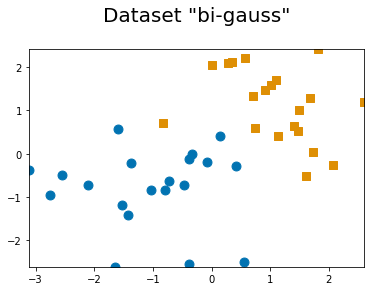

In [4]:
plot_2d(X_1_data_rand_bi_gauss, Y_1_data_rand_bi_gauss)
plt.title('Dataset "bi-gauss"\n', size=20)

#### Réponse : 

La fonction **rand_bi_gauss** retourne des points d'observations (data points) généré aléatoirement suivant 2 lois gaussiennes de paramètres (mu1, sigma1) pour la première loi et (mu2,sigma2) pour la seconde loi.
Enfin la fonction retourne les labels associés à chaque observation qui sont -1 ou 1.

##### rand_tri_gauss pour : 
- chaque classe centrée $(1,1)^{T}, (-1,-1)^{T} et (1,-1)^{T}$
- Ecart type 0.9 pour chaque classe

In [5]:
X_2_data_rand_tri_gauss, Y_2_data_rand_tri_gauss = rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9],
                   sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])
print(X_2_data_rand_tri_gauss)
print("\n\n")
print(Y_2_data_rand_tri_gauss)

[[ 1.27204257e+00  3.53356384e-01]
 [-9.47205938e-01 -3.20317864e-01]
 [-2.26246722e-01  2.61988718e-02]
 [-5.59825306e-01  5.47187471e-01]
 [ 8.57126209e-01  2.41779829e-03]
 [-2.69199370e+00 -5.69584831e-01]
 [-1.52860854e+00 -1.36263989e-01]
 [ 1.69679260e+00 -3.20940181e-01]
 [-9.25964921e-01 -2.52975859e+00]
 [-1.56058649e+00 -1.84475860e-01]
 [ 1.53148099e+00 -8.57125504e-01]
 [ 9.90030476e-01 -1.48112236e+00]
 [ 1.79456417e+00  2.36988135e+00]
 [-1.35948652e+00 -5.57875618e-01]
 [ 2.04652452e+00 -2.03129933e-02]
 [ 9.86570710e-01  1.44960885e+00]
 [-2.60134265e+00 -4.18891085e-01]
 [ 6.22388914e-01 -4.42002693e-01]
 [ 1.25777340e+00 -2.39808056e-01]
 [-1.00323659e+00 -3.90528474e-01]
 [-1.64086040e+00 -9.07166365e-01]
 [ 9.67488371e-01  1.72933632e+00]
 [-1.26017262e+00  1.34840341e-01]
 [ 5.68490035e-01  1.60681867e+00]
 [ 2.45214286e+00  2.56418215e-01]
 [-1.48713107e+00 -1.04030523e+00]
 [-2.06308549e+00 -1.08389087e+00]
 [ 1.53230224e+00 -3.56497969e-01]
 [ 1.58067013e+00  3

Text(0.5, 1.0, 'Dataset "tri-gauss"\n')

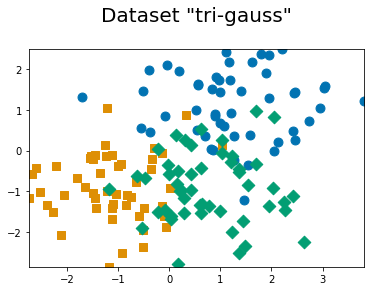

In [6]:
plot_2d(X_2_data_rand_tri_gauss, Y_2_data_rand_tri_gauss)
plt.title('Dataset "tri-gauss"\n', size=20)

#### Réponse : 

La fonction **rand_tri_gauss** retourne des points d'observations (data points) générés aléatoirement suivant 3 lois gaussiennes de paramètres (mu1, sigma1) pour la première loi, (mu2,sigma2) pour la seconde loi et (mu3,sigma3) pour la troisème loi.
Enfin la fonction retourne les labels associés à chaque observation qui sont 1, 2 ou 3.

##### rand_clown pour : 
- Valeur 50 pour le premier deuxième argument
- 1 pour le troisième argument
- 5 pour la quatrième argument

In [7]:
X_3_data_rand_clown, Y_3_data_rand_clown = rand_clown(n1=150, n2=150, sigma1=1, sigma2=2)

print(X_3_data_rand_clown)
print("\n\n")
print(Y_3_data_rand_clown)

[[ 1.67443825e+00  3.27869775e+00]
 [-5.87746518e-02 -2.57411290e-01]
 [ 7.18740935e-01 -9.48505116e-01]
 [-5.35810036e-01  2.21929794e+00]
 [-9.33857594e-01  1.25735107e+00]
 [ 4.93322427e-01  1.95890214e+00]
 [-1.37053236e+00  1.10891422e+00]
 [-7.13362417e-01  4.96869927e+00]
 [ 9.96756191e-02 -5.57649363e-01]
 [-5.62710084e-01  3.29923523e+00]
 [-1.59731292e+00  4.10444513e+00]
 [-1.30514296e+00  6.36581848e-01]
 [ 5.28206895e-01  7.95998098e-01]
 [ 8.16052804e-01  2.64755672e+00]
 [-8.60932200e-02  2.79139126e-01]
 [ 6.28419181e-02  2.65964922e+00]
 [ 1.68523324e+00  3.51100815e+00]
 [-3.36059093e-02 -1.75152042e+00]
 [ 1.82556642e+00  4.93861376e+00]
 [-1.19261421e+00  3.09957318e+00]
 [-1.03939150e+00  1.88832543e+00]
 [-9.42902507e-01  1.04442133e+00]
 [-6.26093828e-01  3.43854572e+00]
 [-1.10339412e+00  2.21122643e+00]
 [ 4.36347094e+00  1.44279877e+00]
 [-1.45689558e+00  7.36055803e-01]
 [ 3.54241711e+00  5.78743002e+00]
 [-1.10091123e+00  2.99200135e+00]
 [-2.69561665e+00 -1

Text(0.5, 1.0, 'Dataset "clown"\n')

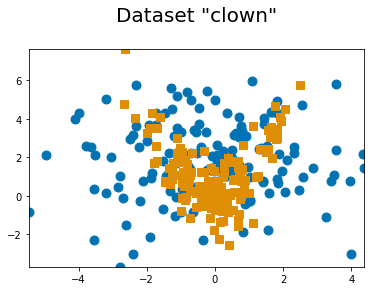

In [8]:
plot_2d(X_3_data_rand_clown, Y_3_data_rand_clown)
plt.title('Dataset "clown"\n', size=20)

#### Réponse : 

La fonction **rand_clown** retourne des points d'observations (data points) générés aléatoirement avec du bruit et d'écart-type sigma1 pour la première classe et sigma2 pour la seconde classe
Enfin la fonction retourne les labels associés à chaque observation qui sont -1 ou 1.

##### rand_checkers pour : 
- Valeur 150 pour le premier et le deuxième argument
- On laisse le troisième argument par défaut

In [9]:
X_4_data_rand_checker, Y_4_data_rand_checker = rand_checkers(n1=150, n2=150, sigma=0.1)

print(X_4_data_rand_checker)
print("\n\n")
print(Y_4_data_rand_checker)

[[-2.16534489  0.43269903]
 [ 1.69235326 -0.15740575]
 [ 0.30258256 -1.37765073]
 [ 1.78156033  1.38526551]
 [ 0.31398833 -0.9506944 ]
 [ 0.68195101 -0.1428846 ]
 [ 0.60080195  0.78361517]
 [-0.27300854  1.62621686]
 [-0.25233325 -0.65534091]
 [ 0.95208593  1.21376634]
 [ 0.85641251  0.72596737]
 [ 0.72927996  0.29285423]
 [-1.84947479 -0.26170095]
 [ 0.14391558 -1.75937921]
 [ 1.63754824  1.28296184]
 [-1.86071473  1.15771803]
 [ 0.10350416  1.00848481]
 [ 0.39100768 -0.92357438]
 [ 1.39561029  1.29504059]
 [-1.03304253  0.89811528]
 [ 0.06443549 -0.32911224]
 [ 0.82780311  1.25310352]
 [ 0.3133189  -0.04292179]
 [ 0.91918932 -1.73016591]
 [ 1.65767784 -1.53901589]
 [-1.32322101 -0.58722138]
 [-1.44348585  0.64376448]
 [-0.91448937  0.9891676 ]
 [-1.0022284   0.39439126]
 [ 1.50474858 -0.60526527]
 [ 0.87847932 -0.24157145]
 [-0.27747051  0.49332358]
 [ 1.48787453 -1.15573996]
 [ 1.31592854 -1.67659284]
 [ 1.24646921 -0.22750102]
 [-0.79981457 -1.08278402]
 [ 0.98457379  0.01667166]
 

Text(0.5, 1.0, 'Dataset "checker"\n')

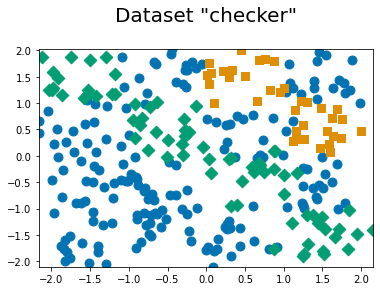

In [10]:
plot_2d(X_4_data_rand_checker, Y_4_data_rand_checker)
plt.title('Dataset "checker"\n', size=20)

#### Réponse : 

La fonction **rand_checker** retourne des points d'observations (data points) générés aléatoirement avec du bruit et d'écart-type sigma 0.1
Enfin la fonction retourne les labels associés à chaque observation qui sont 1, 2 ou 3.

### K-Plus proches voisins (K-NN)

#### Approche intuitive

#### Question 3 : 
L'objectif de la méthode K-NN est de prédire la classe d'un point selon la classe majoritaire de ses $K$ plus proche voisins.

Pour l'approche intuitive (i.e régression) l'idée est de calculer la moyenne des labels du point courant (point dont il faut prédire la classe) et tout ses $K$ plus proche voisins. 

Pour ce faire la classe prédite du point courant peut être calculée avec la formule suivante : 
$\hat{y}=\frac{1}{k} \sum_{i=1}^{n} y_{i}$ la moyenne <br> avec : 
- l'indice k étant le nombre des plus proches voisins du point x. 

Ainsi, on fait la moyenne sur tous les y_i (les labels des plus proches voisins de x)



#### Question 4 :

#### Les étapes de l'implémentation 

**Etape 1** : On calcul la distance entre le point dont il faut prédire la classe et tous les points du dataset. On stocke ces valeurs de distance dans un tableau

distance_euclidienne = $\hat{y}=\sqrt\sum_{i=1}^{n} (y_{i}-x_{i})^{2}$

**Etape_2** : On ordonne ce tableau dans l'ordre croissant (plus petite distance à la plus grande distance)

**Etape_3** : On garde les **K** plus petite distance. **K** est paramètre intialisé au début de l'algorithme (choisi par l'utilisateur)

**Etape_4** : On regarde la classe des points qui ont les **K** plus petite distance. 

**Etape_5** : La classe majoritaire devient la classe du point à prédire. (vote de la majorité)

##### Algorithme KNN from scratch

In [11]:
# from sklearn.base import BaseEstimator, ClassifierMixin
# from collections import Counter
# from sklearn.metrics.pairwise import euclidean_distances

# class KNNClassifier(BaseEstimator, ClassifierMixin):
    
#     """ Homemade kNN classifier class """

#     def __init__(self, n_neighbors=5):
#         # Complete the mehtod
#         self.n_neighbors = n_neighbors

#     def fit(self, X, y):
#         # Complete the mehtod
#         self.X = X
#         self.y = y
#         return self.X,self.y

#     def predict(self, X):
        
#         # Etape 1 : Calcul des distances euclidiennes 
#         list_dist = euclidean_distances(self.X, X)
#         #print(list_dist)
        
#         # Etape 2 : Construction une liste d'index pour lesquels la distance est la plus petite  
#         index_dist_ = np.argsort(list_dist, axis=1)
#         #print(index_dist_)

#         # Etape 3 : On ne garde que les K plus proches voisins (i.e on ne garde que les K plus petite distance)
#         index_dist_min = index_dist_[:, :self.n_neighbors]
#         #print(index_dist_min)

#         # Etape 4 : On construit la liste des classes pour lequel 
#         class_list = list()
#         for i in range(len(index_dist_min)):
#             class_list_temp = list()
#             for idx in index_dist_min[i]: 
#                 num_class = self.y[idx]
#                 class_list_temp.append(num_class)
#             class_list.append(class_list_temp)
#         #print(class_list)  

#         # 5ème étape : Vote majoritaire
#         class_list_majoritaire = list()

#         for i in range(len(class_list)):
#             class_counter = Counter(class_list[i])
#             #print(class_counter)
#             sorted_classes = sorted(class_counter.items(), key = lambda x: x[1], reverse = True)
#             classe_majoritaire = sorted_classes[0][0]
#             class_list_majoritaire.append(classe_majoritaire)
#             #print(class_list_majoritaire)
#         return class_list_majoritaire

#### Construction du jeu de données $X_{train}, y_{train}, X_{test}, y_{test}$ 

In [12]:
# def Xtrain(X):
#     Xred= [X[i] for i in range(len(X)) if i%2==0]
#     return Xred
# def Ytrain(Y):
#     Yred= [Y[i] for i in range(len(Y)) if i%2==0]
#     return Yred

# def Xtest(X):
#     Xt= [X[i] for i in range(len(X)) if i%2!=0]
#     return Xt
# def Ytest(Y):
#     Yt= [Y[i] for i in range(len(Y)) if i%2!=0]
#     return Yt

In [13]:
def Xtrain(X):
    Xred= [i for i in range(len(X)) if i%2==0]
    return Xred
def Ytrain(Y):
    Yred= [i for i in range(len(Y)) if i%2==0]
    return Yred

def Xtest(X):
    Xt= [i for i in range(len(X)) if i%2!=0]
    return Xt
def Ytest(Y):
    Yt= [i for i in range(len(Y)) if i%2!=0]
    return Yt

In [14]:
x__train = Xtrain(X_2_data_rand_tri_gauss) # pair
x__test = Xtest(X_2_data_rand_tri_gauss) # impair

##### Génération des données avec rand_tri_gauss

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_knn = Xtrain(X_2_data_rand_tri_gauss)
print(x_train_knn)
x_train_knn = scaler.fit_transform(x_train_knn)

y_train_knn = Ytrain(pd.Series(Y_2_data_rand_tri_gauss))
y_train_knn = pd.Series(Y_2_data_rand_tri_gauss).iloc[x__train]

x_test_knn = Xtest(X_2_data_rand_tri_gauss)
x_test_knn = scaler.transform(x_test_knn)

y_test_knn = Ytest(pd.Series(Y_2_data_rand_tri_gauss))
y_test_knn = pd.Series(Y_2_data_rand_tri_gauss).iloc[x__test]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148]


ValueError: Expected 2D array, got 1D array instead:
array=[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# y_train_knn = pd.Series(Y_2_data_rand_tri_gauss).iloc[x__train]
# print(y_train_knn)

# y_test_knn = pd.Series(Y_2_data_rand_tri_gauss).iloc[x__test]
# print(y_test_knn)

# print(x_train_knn)

# print(x_test_knn)

In [ ]:
import pandas as pd
# Counter to help with label voting
from collections import Counter

def euclidean_distance(a, b):
    
    # sauvegardons la dimension de a
    dim = len(a)
    
    # initialisons la distance
    distance = 0
    
    # Calculons la distances euclidienne
    for d in range(dim):
        distance += abs(a[d] - b[d])**2
        
    distance = distance**(1/2)
    
    return distance

def KNNClassifier1(X_train, X_test, y_train, y_test, k):
    
    # Faisons une prédiction sur notre dataset
    output = []

    for test_point in X_test:
        distances = []

        for train_point in X_train:
            distance = euclidean_distance(test_point, train_point)
            distances.append(distance)
        
        # Rangeons ces distances dans un dataframe
        df_dists = pd.DataFrame(data=distances, columns=['dist'], index=y_train.index)
        
        # Trions ces distances par ordre croissant et prenons les k premières distances
        df_nn = df_dists.sort_values(by=['dist'], axis=0)[:k]
        
        # On crée un compteur pour regarder les labels des k voisins les plus proches
        counter = Counter(y_train[df_nn.index])

        # Prenons le labels le plus fréquent parmis notre dictionnaire de labels
        prediction = counter.most_common()[0][0]
        
        # ajoutons notre prédiction à notre liste output
        output.append(prediction)
        
    return output


In [ ]:
knn = KNNClassifier()
knn.fit(x_train_knn, y_train_knn)
class_pred = knn.predict(x_test_knn)
print(class_pred)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3, metric = 'euclidean')
model.fit(x_train_knn,y_train_knn)
predicted= model.predict(x_test_knn)
print(predicted)

In [ ]:
def score(X_pred, y):
    counter = 0
    for i in range(len(X_pred)):
        if X_pred[i] == y[i]:
            counter = counter + 1
    return (counter*100)/len(X_pred)

score_knn_homemade = score(class_pred, y_test_knn)
print("Le score obtenu par la version from scratch du modèle KNN fait maison est de : " + str(score_knn_homemade) + " %")

score_knn_scikit_learn = score(predicted, y_test_knn)
print("Le score obtenu par le modèle KNN de scikit learn est de : " + str(score_knn_scikit_learn) + " %")

#### Question 5 :

Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant la distance euclidienne classique d(x; v) = kx 􀀀 vk2 et k = 5. Visualisez les règles de classification obtenues en utilisant la fonction frontiere_new. (Souvent, les autres choix de distance peuvent être utiles, par exemple la distance de Mahalanobis.)

In [ ]:
# TP Perceptron

def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

#### On lance l'algorithme KNN classifier de scikit-learn sur les dataset défini tout au début

#### Dataset #1 :  _rand_bi_gaud_